In [49]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vit_b_16, vit_b_32, vit_l_16, vit_l_32, vit_h_14

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
""" 
Extracts the features of the images in the MNIST dataset using the trained vision transformer.
This way the database of MNIST images becomes a database of MNIST trasnformer feature representations.
Python notebook is used to test the code before running it fully as a pure Python script. 

Steps:
    1. Load the trained transformer model
    2. Strip off the final classification layer
    3. Go through images and forward propagate them
    4. For each image save the final transformer layer representation of that image.
"""

run_on_server = True

In [55]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

train_set = torchvision.datasets.CIFAR10(root='../datasets/CIFAR-10', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../datasets/CIFAR-10', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


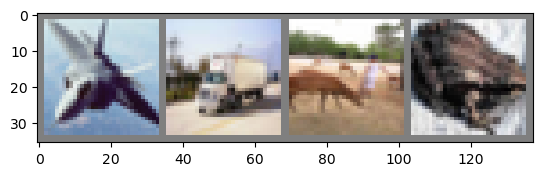

plane truck deer  frog 


In [56]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [53]:
# Load the model
vit_b16_weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1
vit_b16_model = vit_b_16(weights=vit_b16_weights)

# Swap out its MLP for Identity, to extract the features of input images
vit_b16_model.heads = torch.nn.Identity()
vit_b16_model.eval()

# Instantiate the image transform required for the pretraining dataset
vit_b16_transform = vit_b16_weights.transforms()

In [79]:
# Check that folders exist
features_folder = "./CIFAR-10/"
train_features_file = "training_mnist.pkl"
test_features_file = "test_mnist.pkl"

train_features_path = features_folder + train_features_file
test_features_path = features_folder + test_features_file

if not os.path.exists(features_folder):
    raise Exception("Extracted features folder does not exist.")

# Defining run options
model = vit_b16_model
model_transform = vit_b16_transform
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

# Pandas dataframe containing flattened images, their corresponding features and labels (can be expanded with more features from other models)
training_df = pd.DataFrame(columns=['image','label','vit_b16_features'])
test_df = pd.DataFrame(columns=['image','label','vit_b16_features'])

# Main feature extraction loop
with torch.no_grad():
    # Feature extraction loop: Training set
    i = 0
    for batch in train_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        images_features = model(model_transform(images))
        new_rows = pd.DataFrame([{'image': images[i].cpu(), 'vit_b16_features': images_features[i].cpu(), 'label': labels[i].cpu().item()} for i in range(batch_size)]) # saves an image CxHxW, and features
        training_df = pd.concat([training_df, new_rows], ignore_index=True)
        i+=1
        if i == 3:
            break

    # Feature extraction loop: Test set
    i = 0
    for batch in test_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        images_features = model(model_transform(images))
        new_rows = pd.DataFrame([{'image': images[i].cpu(), 'vit_b16_features': images_features[i].cpu(), 'label': labels[i].cpu()} for i in range(batch_size)])
        test_df = pd.concat([test_df, new_rows], ignore_index=True)
        i += 1
        if i == 3:
            break

# Saving the dataframes with extracted features
training_df.to_pickle(train_features_path) #"/training_mnist.pkl")
test_df.to_pickle(test_features_path) #"/test_mnist.pkl")

print('Sucessfully saved the dataframes containing extracted features in pickle files.')


Using device:  cpu 
Sucessfully saved the dataframes containing extracted features in pickle files.
